# Trabalho de Machine Learning

#### Igor Patrício Michels

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from itertools                 import product

from sklearn.metrics           import *
from sklearn.base              import clone
from sklearn.tree              import plot_tree
from sklearn.tree              import export_text
from sklearn.model_selection   import cross_val_score
from sklearn.model_selection   import train_test_split
from sklearn.linear_model      import LogisticRegression
from sklearn.exceptions        import ConvergenceWarning
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import GradientBoostingClassifier

from warnings import simplefilter
simplefilter('ignore', category = ConvergenceWarning)

Nessa segunda parte irei comparar a eficiência de quatro modelos de classificação quando testados sobre o dataset escolhido. São eles:
 - Regresão Logística
 - Decision Tree
 - Random Forest
 - Gradient Boosting

Para tanto, declarei uma função que testa alguns valores de parâmetros e retorna o modelo que performa com os parâmetros testados. Essa performance é calculada por meio do cross-validation com $5$ grupos. Assim, para cada um dos modelos acima, foram propostos um conjunto de parâmetros e os mesmos foram avaliados com o cross-validation, retornando o modelo dado com os melhores parâmetros segundo a validação.

Além dessa função, também declarei duas funções para avaliar os resultados, uma retornando a matriz de confusão, bem como algumas outras métricas, e outra que plota a curva ROC para o modelo.

## Leitura e Processamento dos dados

In [2]:
df = pd.read_csv('dados_limpos.csv')
variables = df.columns.to_list()
variables.remove('reservation_status')
variables.remove('reservation_status_date')

df1 = df[variables]
df = df1

In [3]:
categorical_variables = ['hotel', 'meal', 'market_segment', 'distribution_channel',
                         'reserved_room_type', 'assigned_room_type', 'deposit_type',
                         'customer_type']

for variable in categorical_variables:
    cat_list = 'var' + '_' + variable
    cat_list = pd.get_dummies(df[variable], prefix = variable)
    df1 = df.join(cat_list)
    df = df1
    
data_vars = df.columns.values.tolist()
manter = [i for i in data_vars if i not in categorical_variables]
df1 = df[manter]
df = df1
del df1
del manter

In [4]:
X = df.loc[:, df.columns != 'is_canceled']
y = df.loc[:, df.columns == 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [5]:
def metrics1(classificador, X_test, y_test, name = ''):
    y_pred = classificador.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, 
                fmt = '.2%', cmap = 'Blues')
    
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png')
    plt.show()

def metrics2(X_test, y_test, classificador, nome_classificador):
    roc_auc = roc_auc_score(y_test, classificador.predict(X_test))
    fpr, tpr, _ = roc_curve(y_test, classificador.predict_proba(X_test)[:, 1])
    
    plt.figure()
    plt.plot(fpr, tpr, label = nome_classificador + ' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Razão de falso positivo')
    plt.ylabel('Razão de verdadeiro positivo')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()
    
    return fpr, tpr, roc_auc

def find_parameters(model, model_name, X_train, y_train, X_test, y_test, params):
    max_score = 0
    for param in product(*params):
        if model_name == 'Regressão Logística':
            model.C = param[0]
        elif model_name == 'Decision Tree':
            model.max_depth = param[0]
            model.min_samples_split = param[1]
        elif model_name == 'Random Forest':
            model.n_estimators = param[0]
            model.max_depth = param[1]
            model.min_samples_split = param[2]
        else:
            # gradient boosting
            model.n_estimators = param[0]
            model.max_depth = param[1]
            model.learning_rate = param[2]
        
        scores_i = cross_val_score(model, X_train, y_train, cv = 5)
        if np.mean(scores_i) > max_score:
            optimal_model = clone(model)
            max_score = np.mean(scores_i)
    
    return optimal_model

## Regressão Logística

In [6]:
%%time
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
logreg = LogisticRegression(random_state = 0)
logreg = find_parameters(logreg, 'Regressão Logística', X_train, y_train, X_test, y_test, [C])

CPU times: user 2min 20s, sys: 53.1 s, total: 3min 14s
Wall time: 56.7 s


In [7]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 4.58 s, sys: 1.79 s, total: 6.36 s
Wall time: 1.68 s


LogisticRegression(C=0.1, random_state=0)

              precision    recall  f1-score   support

           0       0.76      0.89      0.82     18471
           1       0.76      0.55      0.64     11729

    accuracy                           0.76     30200
   macro avg       0.76      0.72      0.73     30200
weighted avg       0.76      0.76      0.75     30200



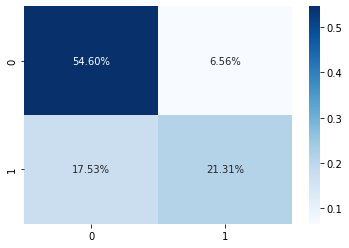

In [8]:
metrics1(logreg, X_test, y_test, 'Logistic Regression')

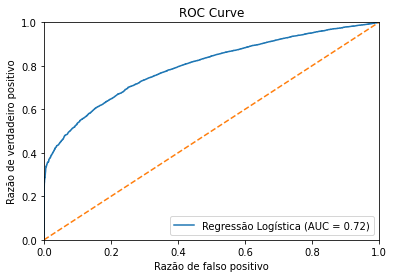

In [9]:
logreg_fpr, logreg_tpr, logreg_roc_auc = metrics2(X_test, y_test, logreg, 'Regressão Logística')

## Decision Tree

In [10]:
%%time
max_depth = [1, 5, 10, 15, 20, 25]
min_samples_split = [50, 100, 200, 400]
dtc = DecisionTreeClassifier(random_state = 0)
dtc = find_parameters(dtc, 'Decision Tree', X_train, y_train, X_test, y_test, [max_depth, 
                                                                               min_samples_split])

CPU times: user 46.1 s, sys: 1.33 s, total: 47.5 s
Wall time: 47.5 s


In [11]:
%%time
dtc.fit(X_train, y_train)

CPU times: user 656 ms, sys: 9.06 ms, total: 665 ms
Wall time: 663 ms


DecisionTreeClassifier(max_depth=15, min_samples_split=50, random_state=0)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     18471
           1       0.83      0.80      0.81     11729

    accuracy                           0.86     30200
   macro avg       0.85      0.85      0.85     30200
weighted avg       0.86      0.86      0.86     30200



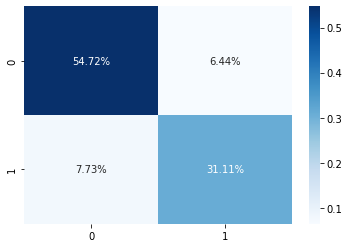

In [12]:
metrics1(dtc, X_test, y_test, 'Decision Tree')

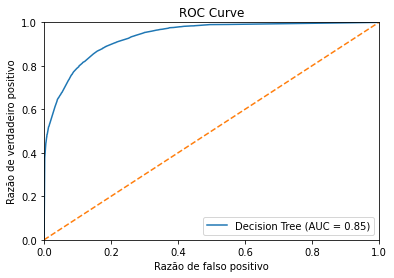

In [13]:
dtc_fpr, dtc_tpr, dtc_roc_auc = metrics2(X_test, y_test, dtc, 'Decision Tree')

## Random Forest

In [14]:
%%time
estimators = [10, 50, 100]
max_depth = [1, 5, 10, 15, 20, 25]
min_samples_split = [50, 100, 200, 400]
rfc = RandomForestClassifier(random_state = 0)
rfc = find_parameters(rfc, 'Random Forest', X_train, y_train, X_test, y_test, [estimators,
                                                                               max_depth,
                                                                               min_samples_split])

CPU times: user 12min 45s, sys: 1.62 s, total: 12min 47s
Wall time: 12min 47s


In [15]:
%%time
rfc.fit(X_train, y_train)

CPU times: user 8.04 s, sys: 8.71 ms, total: 8.05 s
Wall time: 8.05 s


RandomForestClassifier(max_depth=25, min_samples_split=50, random_state=0)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18471
           1       0.88      0.78      0.83     11729

    accuracy                           0.87     30200
   macro avg       0.87      0.86      0.86     30200
weighted avg       0.87      0.87      0.87     30200



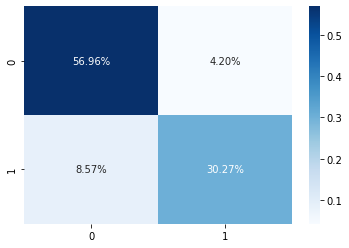

In [16]:
metrics1(rfc, X_test, y_test, 'Random Forest')

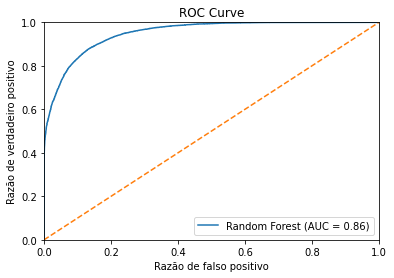

In [17]:
rfc_fpr, rfc_tpr, rfc_roc_auc = metrics2(X_test, y_test, rfc, 'Random Forest')

## Gradient Boosting

In [18]:
%%time
estimators = [1, 5, 10, 50]
max_depth = [1, 5, 10] 
learning_rate = [0.1, 0.5, 1, 5, 10]
gbc = GradientBoostingClassifier(random_state = 0)
gbc = find_parameters(gbc, 'Gradient Boosting', X_train, y_train, X_test, y_test, [estimators,
                                                                                   max_depth,
                                                                                   learning_rate])

CPU times: user 19min 42s, sys: 645 ms, total: 19min 43s
Wall time: 19min 43s


In [19]:
%%time
gbc.fit(X_train, y_train)

CPU times: user 28.8 s, sys: 4.57 ms, total: 28.8 s
Wall time: 28.8 s


GradientBoostingClassifier(learning_rate=0.5, max_depth=10, n_estimators=50,
                           random_state=0)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     18471
           1       0.85      0.84      0.84     11729

    accuracy                           0.88     30200
   macro avg       0.88      0.87      0.87     30200
weighted avg       0.88      0.88      0.88     30200



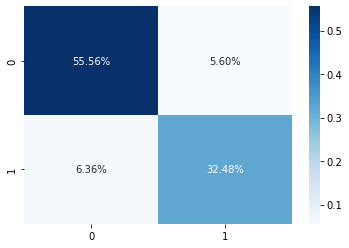

In [20]:
metrics1(gbc, X_test, y_test, 'Gradient Boosting')

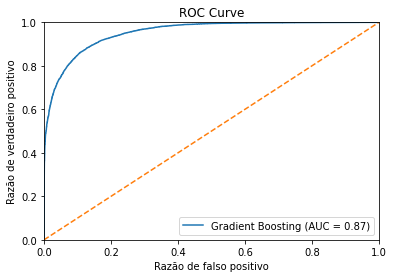

In [21]:
gbc_fpr, gbc_tpr, gbc_roc_auc = metrics2(X_test, y_test, gbc, 'Gradient Boosting')

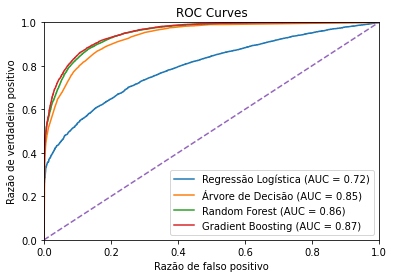

In [22]:
plt.plot(logreg_fpr, logreg_tpr, label = 'Regressão Logística (AUC = %0.2f)' % logreg_roc_auc)
plt.plot(dtc_fpr, dtc_tpr, label = 'Árvore de Decisão (AUC = %0.2f)' % dtc_roc_auc)
plt.plot(rfc_fpr, rfc_tpr, label = 'Random Forest (AUC = %0.2f)' % rfc_roc_auc)
plt.plot(gbc_fpr, gbc_tpr, label = 'Gradient Boosting (AUC = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Razão de falso positivo')
plt.ylabel('Razão de verdadeiro positivo')
plt.title('ROC Curves')
plt.legend(loc = 'lower right')
plt.savefig('ROC_curves.png')
plt.show()

## Breve Análise das Árvores

Na primeira parte um gráfico que chamou muita atenção foi o seguinte:

<img src = "download.png" width = "1200" alt>

Onde pudemos ver que essas duas variáveis conseguem separar bem os grupos. Assim, poderíamos dizer que "pessoas que reservam vagas de estacionamento ou fazem pedidos especiais não irão cancelar a reserva".

Como a ideia por trás das árvores de decisão segue uma ideia similar aos processos de decisão de nós, seres humanos, podemos ver de que modo tais decisões são realizadas pelo modelo.

### Decision Tree

In [23]:
print(export_text(dtc, feature_names = X.columns.to_list(), max_depth = 2))

|--- deposit_type_Non Refund <= 0.50
|   |--- previous_cancellations <= 0.50
|   |   |--- market_segment_Online TA <= 0.50
|   |   |   |--- truncated branch of depth 13
|   |   |--- market_segment_Online TA >  0.50
|   |   |   |--- truncated branch of depth 13
|   |--- previous_cancellations >  0.50
|   |   |--- previous_bookings_not_canceled <= 1.50
|   |   |   |--- truncated branch of depth 5
|   |   |--- previous_bookings_not_canceled >  1.50
|   |   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- InternationalCustomer <= 0.50
|   |   |--- assigned_room_type_F <= 0.50
|   |   |   |--- truncated branch of depth 4
|   |   |--- assigned_room_type_F >  0.50
|   |   |   |--- class: 0
|   |--- InternationalCustomer >  0.50
|   |   |--- customer_type_Transient-Party <= 0.50
|   |   |   |--- class: 1
|   |   |--- customer_type_Transient-Party >  0.50
|   |   |   |--- class: 0



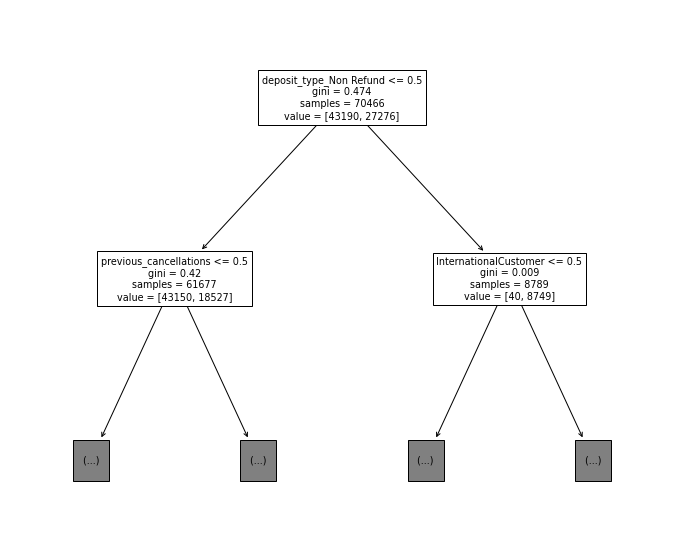

In [24]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
plot_tree(dtc, feature_names = X.columns.to_list(), max_depth = 1)
plt.savefig('Decision_Tree.png')

### Random Forest

In [25]:
print(export_text(rfc.estimators_[0], feature_names = X.columns.to_list(), max_depth = 2))

|--- total_of_special_requests <= 0.50
|   |--- assigned_room_type_A <= 0.50
|   |   |--- market_segment_Online TA <= 0.50
|   |   |   |--- truncated branch of depth 17
|   |   |--- market_segment_Online TA >  0.50
|   |   |   |--- truncated branch of depth 23
|   |--- assigned_room_type_A >  0.50
|   |   |--- deposit_type_No Deposit <= 0.50
|   |   |   |--- truncated branch of depth 7
|   |   |--- deposit_type_No Deposit >  0.50
|   |   |   |--- truncated branch of depth 23
|--- total_of_special_requests >  0.50
|   |--- arrival_date_year <= 2016.50
|   |   |--- lead_time <= 9.50
|   |   |   |--- truncated branch of depth 13
|   |   |--- lead_time >  9.50
|   |   |   |--- truncated branch of depth 23
|   |--- arrival_date_year >  2016.50
|   |   |--- agent <= 7.50
|   |   |   |--- truncated branch of depth 16
|   |   |--- agent >  7.50
|   |   |   |--- truncated branch of depth 23



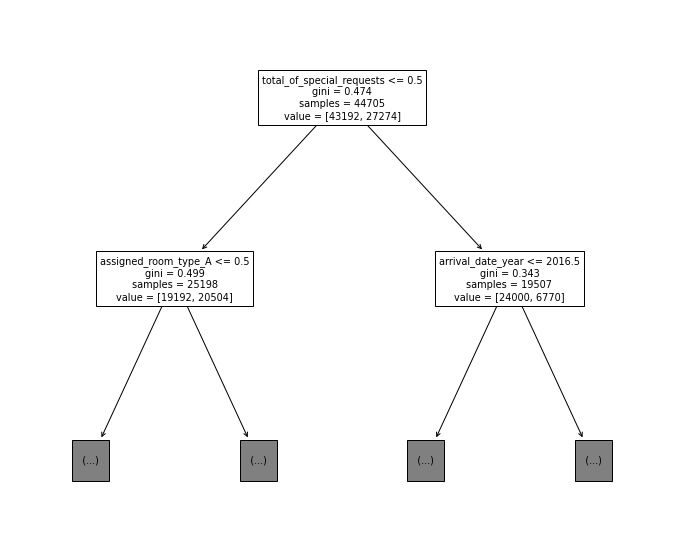

In [26]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
plot_tree(rfc.estimators_[0], feature_names = X.columns.to_list(), max_depth = 1)
plt.savefig('Random_Forest_Tree.png')